# Sleep research: Programming Challenge

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import os

In [8]:
#Get working directory
os.getcwd()

'C:\\Users\\Casper Damen\\DiP\\Python klasje\\notebooks'

In [9]:
#Set working directory
os.chdir('C:\\Users\\Casper Damen\\DiP\\Python klasje\\data')

In [10]:
df = pd.read_csv('sleep_deprived_coding.csv')

In [11]:
df.head()

,id,gpa,sleep,passed_unit_tests,passed_asserts,tackled_user_stories
0,1,23,normal,5,6,5
1,2,24,normal,1,3,2
2,3,23,normal,7,6,5
3,4,28,normal,5,8,4
4,5,25,normal,4,5,3


In [40]:
df.describe()

,id,gpa,passed_unit_tests,passed_asserts,tackled_user_stories
count,36.000000,36.000000,36.000000,36.000000,36.00000
mean,20.944444,24.194444,2.166667,4.250000,2.25000
std,12.857337,2.025825,2.248809,1.696635,1.40153
min,1.000000,20.000000,0.000000,2.000000,0.00000
25%,10.750000,23.000000,0.000000,3.000000,1.00000
50%,19.500000,24.000000,1.000000,4.000000,2.00000
75%,31.250000,25.250000,4.000000,5.000000,3.00000
max,45.000000,28.000000,7.000000,8.000000,5.00000


## Data Exploration

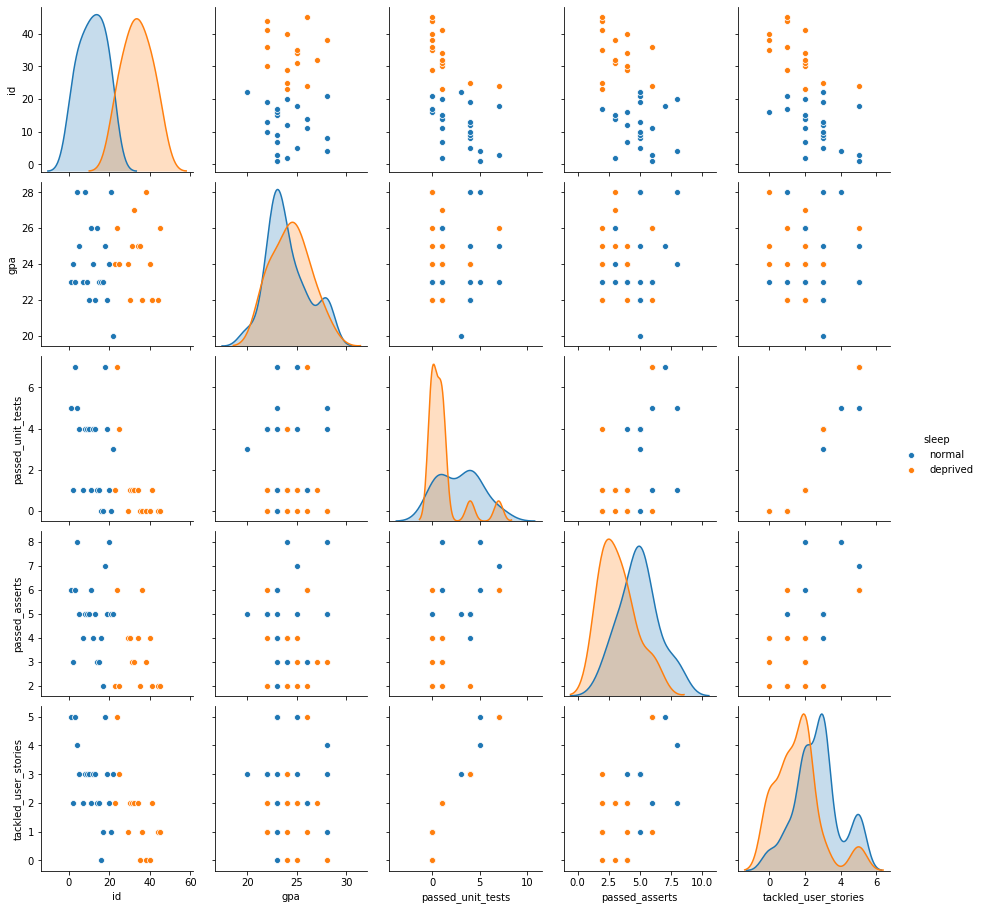

In [361]:
#Visualize the distribution using normal/deprived as hue
sns.pairplot(df, hue='sleep')

In [362]:
#Create function to generate aggregated table grouped by normal and deprived
def aggregate_sleep_groups(dataf):
    
    agg_dataf = (dataf
                 .groupby('sleep')
                 .agg(n=('id', 'count'),
                      mean_gpa=('gpa', np.mean),
                      mean_unit_tests=('passed_unit_tests', np.mean),
                      mean_asserts=('passed_asserts', np.mean),
                      mean_user_stories=('tackled_user_stories', np.mean))
                )
    return agg_dataf

In [364]:
#Use aggregated function to show means from both groups
agg_dataf = df.pipe(aggregate_sleep_groups)
agg_dataf

,n,mean_gpa,mean_unit_tests,mean_asserts,mean_user_stories
sleep,,,,,
deprived,15,24.400000,1.133333,3.266667,1.600000
normal,21,24.047619,2.904762,4.952381,2.714286


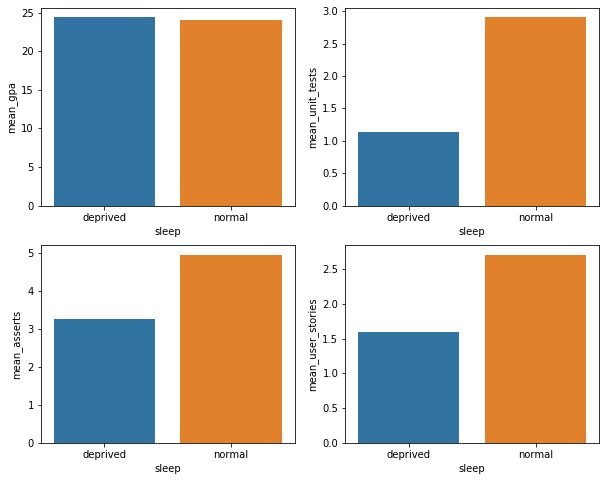

In [312]:
#Visualize the difference using barplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(10,8),nrows=2, ncols=2, sharex=False, sharey=False)

for ax, column in zip(fig.axes, agg_dataf.columns[1:]):
    sns.barplot(x=agg_dataf.index, y=column, data=agg_dataf, ax=ax)

## Sampling
In order to check whether the observed coding performance difference between the sleep and deprived group is due to chance, we are going to take a lot of random samples and check the mean distribution.

In [366]:
#Two functions to take random samples and calculate the difference.

#Function to shuffle id's and assign deprived (15) versus normal (21) randomly.
def reshuffle(dataf):
    
    shuffled_dataf = (dataf
                      .sample(dataf['id'].count())
                      .reset_index(drop=True)
                      .assign(sleep=lambda d: np.where(d.index < 15, 'deprived', 'normal'))
                     )
    
    return shuffled_dataf

#Function to calculate difference between deprived and normal group
def calc_diff_sleep(dataf):
    
    agg_dataf = (dataf
                        .groupby('sleep')
                        .agg(mean_unit_tests=('passed_unit_tests', np.mean),
                             mean_asserts=('passed_asserts', np.mean),
                             mean_user_stories=('tackled_user_stories', np.mean))
                       ).T
    
    difference_dataf = agg_dataf['deprived'] - agg_dataf['normal'] 
    
    return difference_dataf

In [367]:
#Function to store the differences between deprived and normal group from samples, take 1000 samples by default
def shuffle_simulation(dataf, n=1000):
    
    results = np.zeros((n, 3))
    
    for i in range(n):
        results[i, :] = calc_diff_sleep(reshuffle(dataf))
        
    results_difference_dataf = pd.DataFrame(results,
                                            columns=['diff_unit_tests',
                                                     'diff_asserts',
                                                     'diff_user_stories'])
    return results_difference_dataf

In [381]:
sample_dataf_diff = df.pipe(shuffle_simulation)

In [382]:
sample_dataf_diff.head()

,diff_unit_tests,diff_asserts,diff_user_stories
0,0.514286,0.485714,0.371429
1,-0.057143,-0.428571,-0.314286
2,-0.971429,-0.428571,-0.657143
3,-0.742857,-0.314286,-0.771429
4,-0.057143,-0.314286,-0.314286


## Analyze sampling distribution

### Check for differences between sleep and deprived group

In [383]:
#Create function to plot the group difference in sample distributions
#Draw a line to illustrate the difference in the original dataset
def plot_diff(dataf):
    
    plt.figure(figsize=(16,4))

    dict_diff = dict(dataf)

    for idx, name in enumerate(['unit_tests', 'asserts', 'user_stories']):
        plt.subplot(131 + idx)
        plt.hist(sample_dataf_diff[f'diff_{name}'])
        plt.vlines(dict_diff[f'mean_{name}'], 0, 300, color='red')
        plt.title(name)

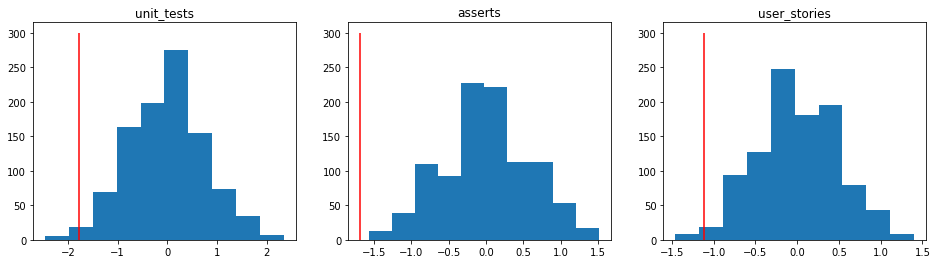

In [384]:
df.pipe(calc_diff_sleep).pipe(plot_diff_sleep)

In [385]:
#Function to return a dataframe with the probabilities to find a difference as big as we found due to chance.
#For the sleep groups
def chance_diff_sleep(sample_dataf, original_dataf):
    
    dict_diff = dict(calc_diff_sleep(original_dataf))
    
    chance_results = {}
    
    for column, value in zip(sample_dataf.columns, dict_diff.values()):
        chance_results[column] = sample_dataf.assign(limit=lambda d: d[column] < value)['limit'].mean()

    chance_dataf = pd.DataFrame(chance_results.values(),
                                index=chance_results.keys(),
                                columns=['chance_diff'])
    
    return chance_dataf    

In [386]:
sample_dataf_diff.pipe(chance_diff_sleep, original_dataf=df)

,chance_diff
diff_unit_tests,0.009
diff_asserts,0.000
diff_user_stories,0.008


### Check for differences between different levels of GPA

In [387]:
#Function to calculate difference between high and low GPA group
def calc_diff_gpa(dataf):
    
    agg_dataf = (dataf
                        .assign(gpa=lambda d: d['gpa'] < d['gpa'].mean())
                        .groupby('gpa')
                        .agg(mean_unit_tests=('passed_unit_tests', np.mean),
                             mean_asserts=('passed_asserts', np.mean),
                             mean_user_stories=('tackled_user_stories', np.mean))
                       ).T
    
    difference_dataf = agg_dataf[False] - agg_dataf[True] 
    
    return difference_dataf

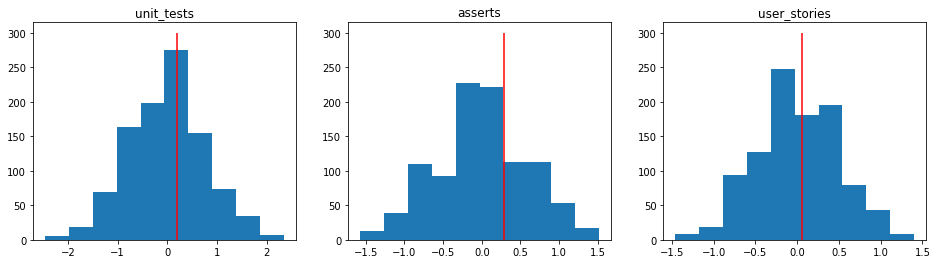

In [388]:
df.pipe(calc_diff_gpa).pipe(plot_diff)

In [389]:
#Function to return a dataframe with the probabilities to find a difference as big as we found due to chance.
#For the GPA groups
def chance_diff_gpa(sample_dataf, original_dataf):
    
    dict_diff = dict(calc_diff_gpa(original_dataf))
    
    chance_results = {}
    
    for column, value in zip(sample_dataf.columns, dict_diff.values()):
        chance_results[column] = sample_dataf.assign(limit=lambda d: d[column] < value)['limit'].mean()

    chance_dataf = pd.DataFrame(chance_results.values(),
                                index=chance_results.keys(),
                                columns=['chance_diff'])

    return chance_dataf  

In [390]:
sample_dataf_diff.pipe(chance_diff_gpa, original_dataf=df)

,chance_diff
diff_unit_tests,0.632
diff_asserts,0.704
diff_user_stories,0.588
